# COMP24112 - Exercise 3: _Face Recognition_ (25 Marks)

## 1. Task description

You will work on the face recognition and face completion tasks. The provided dataset includes face images of 40 subjects. There are a total of 400 images, with 10 images per subject. Each image contains 32×32=1024 pixels, with 256 grey levels per pixel.

## 2. Preparation

### 2.1 Setting up

The functions that you need are defined in the source file we have provided you with. To use them you must import it first:

In [1]:
from lab3lib import load_data, show_single_face, show_faces, partition_data, split_left_right, join_left_right, show_split_faces
import numpy as np
import matplotlib.pyplot as plt


Now you can load the data:

In [2]:
data, labels = load_data()
print(data.shape)
print(labels)

(400, 1024)
[ 1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  3  3  3  3
  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5
  5  5  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  8  8
  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 10 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 12
 13 13 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 14 15 15 15 15
 15 15 15 15 15 15 16 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17
 17 17 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 19 19 20 20
 20 20 20 20 20 20 20 20 21 21 21 21 21 21 21 21 21 21 22 22 22 22 22 22
 22 22 22 22 23 23 23 23 23 23 23 23 23 23 24 24 24 24 24 24 24 24 24 24
 25 25 25 25 25 25 25 25 25 25 26 26 26 26 26 26 26 26 26 26 27 27 27 27
 27 27 27 27 27 27 28 28 28 28 28 28 28 28 28 28 29 29 29 29 29 29 29 29
 29 29 30 30 30 30 30 30 30 30 30 30 31 31 31 31 31 31 31 31 31 31 32 32
 32 32 32 32 32 32 32 32 33 33 33 33 33

### 2.2 Visualising the dataset

You can observe the faces stored in a data matrix by using the functions `show_single_face()` and `show_faces()`.

array([[ 75, 101, 128, ..., 118,  37,  39],
       [110, 124, 144, ...,  33,  33,  33],
       [ 77, 119, 142, ...,  32,  35,  35],
       ...,
       [121, 147, 159, ...,  37,  38,  38],
       [ 52,  53,  51, ...,  98, 126, 141],
       [125,  68,  60, ...,  69,  76,  87]], dtype=uint8)

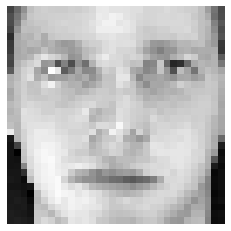

In [3]:
# Display a single example.
show_single_face(data[0, :])
data

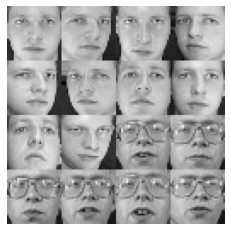

In [4]:
# Display the first 16 examples in a 4x4 grid.
show_faces(data[:16, :], num_per_row=4)
# show_faces(data[:100, :], num_per_row=16)

### 2.3 Splitting into the train and test sets

First, normalize your pixel values by 1/255 so that the feature values used in later experiments are between $[0,1]$. In general, the normalization trick can make it easier for your to tune parameters in machine learning experiments.

A data partition function is supplied to facilitate your experiments. It randomly splits the provided data into the training and test sets, where the training set contains $N$ samples per class and the test set contains
the remaining samples. The function takes the labels and the specified number $N$ as the input. And returns the sample indices in the training and test set. For example, the following code divides a given set of 400 samples into a training set containing 3 samples per subject and a test set containing 7 samples per subject:

In [5]:
# normalization
data = data / 255

# partition
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]

## 3. $L_2$-regularised least squares (13 Marks in Total)
### 3.1 Implementation (5 Marks, Easy)
Now, you need to implement the function `l2_rls_train` below. 

`l2_rls_train` trains a linear model by minimising the $L_2$-regularised sum of squares loss through zeroing the loss gradient. It should support both single-output and multi-output cases. This function should take a set of training samples and a user-specified regularisation parameter $\lambda$ as the input, and return the predicted weights. When $\lambda=0$, use a pseudo-inverse to implement the solution.

In [6]:
def l2_rls_train(data, labels, _lambda # Add any other arguments here
          ):
    """
    A summary of your function goes here.

    data: type and description of "data"
    labels: type and description of "labels"

    Returns: type and description of the returned variable(s).
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    # Expand X with a column of ones.
    X_tilde = np.c_[ np.ones(X.shape[0]), X  ]
    
    # Compute the coefficient vector.
    product = (X_tilde.T)@X_tilde #n>d
    identity = np.eye(product.shape[0])
    if _lambda == 0:
        # Pseudo-inverse formula
        w = np.linalg.pinv(X_tilde) @ y
    else:
        w = (np.linalg.inv(X_tilde.T@X_tilde+_lambda*identity) @ X_tilde.T @ y)
    # Return model parameters.
    return w
# print(l2_rls_train(tr_data, tr_label, 0))

Now, implement the function `l2_rls_predict` below. It should take the trained weights and your query data as the input, and return the corresponding prediction.

In [7]:
def l2_rls_predict(w, data):
    """
    A summary of your function goes here.

    data: type and description of "data"
    w: type and description of "w"

    Returns: type and description of the returned variable(s).
    """
    
   # Compute the prediction.
    X = data
    X_tilde = np.c_[ np.ones(X.shape[0]), X  ] 

    predicted_y = X_tilde @ w
        
    return predicted_y

# res = l2_rls_predict(l2_rls_train(tr_data, tr_label, 0), tr_data)
# print(res)

#### Report

Explain briefly the knowledge supported your implementation and your design step by step.

### 3.2 Experiments (2 experiments to be implemented) 

Use your implemented functions to perform the following experiments. Experiment 1 is compulsory. Between Experiment 2 and Experiment 3, choose one as you like.

#### Experiment 1: Binary Classification (4 Marks, Normal)

Start with a binary classification to classify face images for subjects “1” and “30”.

Train three classifiers:
<br>Classifier 1. Set $y=-1$ for samples from “1” and $y=+1$ for samples from “30” for training a linear model, and use the threshold $T= 0$ to obtain the class prediction.
<br>Classifier 2. Set $y=0$ for samples from “1” and $y=1$ for samples from “30” for training a linear model, and use the threshold $T= 0.5$ to obtain the class prediction.
<br>Classifier 3. Set $y=1$ for samples from “1” and $y=30$ for samples from “30” for training a linear model, and use the threshold $T= 15.5$ to obtain the class prediction.

Randomly select 3 images per subject for training, and use the remaining images for testing. Train your classifier 1 and test it with a fixed regularisation parameter $\lambda$=0. Repeat this process 50 times and record the training and test errors.

In [8]:
# split data samples from class 1 and class 30 into traning set and test set
def choose_data():
    class_1_30_labels = np.concatenate((labels[:10],labels[290:300]))
    class_1_30_data = np.concatenate((data[:10,:], data[290:300, :]))
    tr_1_30_ind, te_1_30_ind = partition_data(class_1_30_labels, num_per_class=3)
    return [class_1_30_data, class_1_30_labels, tr_1_30_ind, te_1_30_ind]

# binary classification of samples from class 1 and class 30
def ex(class_1_30_data, class_1_30_labels, tr_1_30_ind, te_1_30_ind, threshold, class1, class2):
    class_1_30_labels_int = class_1_30_labels.astype(float)
    class_1_30_labels_int[class_1_30_labels_int==1] = class1
    class_1_30_labels_int[class_1_30_labels_int==30] = class2
    weight = l2_rls_train(class_1_30_data[tr_1_30_ind], class_1_30_labels_int[tr_1_30_ind], 0)

    # Classification error rate of test samples
    test_predict = l2_rls_predict(weight, class_1_30_data[te_1_30_ind])
    test_predict[test_predict<threshold] = class1
    test_predict[test_predict>threshold] = class2
    test_error_matrix = class_1_30_labels_int[te_1_30_ind]-test_predict
    test_error_matrix[test_error_matrix!=0]=1
    test_error_number = np.sum(test_error_matrix)
    test_error_rate = test_error_number/14

    # Classidication error rate of traininig samples
    training_predict = l2_rls_predict(weight, class_1_30_data[tr_1_30_ind])
    training_predict[training_predict<=threshold] = class1
    training_predict[training_predict>threshold] = class2
    training_error_matrix = class_1_30_labels_int[tr_1_30_ind]-training_predict
    training_error_matrix[training_error_matrix!=0]=1
    training_error_number = np.sum(training_error_matrix)
    training_error_rate = training_error_number/6

    return (test_error_rate, training_error_rate)

Classifier 1:

In [9]:
# Classifier 1, threshold 0, labels -1, 1
test_error_rates1 = []
training_error_rates1 = []
for i in range(50):
    ls = choose_data()
    result = ex(ls[0], ls[1], ls[2], ls[3], 0, -1, 1)
    test_error_rates1.append(result[0])
    training_error_rates1.append(result[1])

test_error_mean1 = np.mean(test_error_rates1)
training_error_mean1 = np.mean(training_error_rates1)

print(test_error_mean1, training_error_mean1)

0.06285714285714285 0.0


Repeat the same experiment for classifier 2.

In [10]:
# Classifier 2, threshold 0.5, training label 0, 1
test_error_rates2 = []
training_error_rates2 = []
for i in range(50):
    ls = choose_data()
    result = ex(ls[0], ls[1], ls[2], ls[3], 0.5, 0, 1)
    test_error_rates2.append(result[0])
    training_error_rates2.append(result[1])

test_error_mean2 = np.mean(test_error_rates2)
training_error_mean2 = np.mean(training_error_rates2)

print(test_error_mean2, training_error_mean2)

0.05857142857142858 0.0


Repeat the same experiment for classifier 3.

In [11]:
# Classifier 3, threshold 15.5, training lavel 1, 30
test_error_rates3 = []
training_error_rates3 = []
for i in range(50):
    ls = choose_data()
    result = ex(ls[0], ls[1], ls[2], ls[3], 15.5, 1, 30)
    test_error_rates3.append(result[0])
    training_error_rates3.append(result[1])

test_error_mean3 = np.mean(test_error_rates3)
training_error_mean3 = np.mean(training_error_rates3)

print(test_error_mean3, training_error_mean3)

0.08428571428571427 0.0


Print out the mean and the std values of the test errors of the three classifiers.

In [12]:
print("Repeat evaluation for 50 times for each classifier: ")
print("Classifier 1: \ntest error rate mean: %f, test error std: %f, training error rate mean: %f" % (test_error_mean1, np.std(test_error_rates1), training_error_mean1))
print("Classifier 2: \ntest error rate mean: %f, test error std: %f, training error rate mean: %f" % (test_error_mean2, np.std(test_error_rates2), training_error_mean2))
print("Classifier 3: \ntest error rate mean: %f, test error std: %f, training error rate mean: %f" % (test_error_mean3, np.std(test_error_rates3), training_error_mean3))


Repeat evaluation for 50 times for each classifier: 
Classifier 1: 
test error rate mean: 0.062857, test error std: 0.081616, training error rate mean: 0.000000
Classifier 2: 
test error rate mean: 0.058571, test error std: 0.082919, training error rate mean: 0.000000
Classifier 3: 
test error rate mean: 0.084286, test error std: 0.099683, training error rate mean: 0.000000


#### Report

Explain the classification steps. Does changing the class labels impact the model performance? Explain why it does/doesn't impact.  What training accuracies do you obtain with your linear classifier? Analyse the reason.

#### Experiment 2: Multi-class Classification (4 Marks, Normal)

Now, proceed to the multi-class classification task to classify face images for all the 40 subjects.

Split your data to two sets: the training set contains 5 randomly selected images per subject and the test set contains the remaining images. The training set is used to train the model and select hyper-parameter $\lambda$, while the test set is only for final assessment of the trained classifier with the selected $\lambda$. 

Design an appropriate and complete machine learning experiment, which should include the training, hyper-parameter selection and evaluation stages. You can choose from the random subsampling, $k$-fold CV and LOO approaches for hyper-parameter selection. In the evaluation, you should construct a $40\times 40$ classification error matrix (confusion matrix) for test samples. 

Write your code below and make sure it compiles. 

In [13]:
# Note that you may find it helpful to use one-hot encoding to deal with multi-class labels
import pandas as pd
tr_ind, te_ind = partition_data(labels, num_per_class=5)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]

# one-hot encoding of multi-class labels
# every label is 40 length vector, each elements represents a class.
# only the class the sample belongs to is 1, all the other classes are 0
s = pd.Series([i for i in range(1, 41)])
multi_class_labels = pd.get_dummies(s).to_numpy()
multi_class_labels = np.repeat(a = multi_class_labels, repeats = 5, axis = 0)
multi_class_labels_whole = np.repeat(a = multi_class_labels, repeats = 2, axis = 0)

# parameter predict is the matrix of predicted values, every row in this matrix is a 40 length vector.
def eveluate_error_rate(predict, labels, test_num):
    labels = labels.astype(float)
    ones = np.ones_like(predict)
    # pick the predicted value that is the closest to number 1, and this is my predicted class
    # because I  use 1 in one-hot encoding
    dif = ones - predict
    predict_class = np.argsort(dif, axis=1)[:, :1]
    ground_class = np.argsort(-labels, axis=1)[:, :1]
    error_num = predict_class-ground_class
    error_num[error_num!=0]=1
    error_num = np.sum(error_num)
    error_rate = error_num/test_num
    return error_rate


def hyper_para_select(tr_data, multi_class_labels):
    # random subsampling to do Hyperparameter selection
    all_indices = np.arange(0, 200)
    _lambda = np.arange(-25,25,0.5, dtype=float)
    error_rates_mean = []
    for m in range(100):
        error_rates = []
        # for each hyper parameter, I run 10 trials.
        # I use random subsampling to choose training data for each trial
        for i in range(10):
            test_data_indices = np.random.choice(200, 20, replace=False)
            random_tr_indices = [item for item in all_indices if item not in test_data_indices]

            validation_tr_data = tr_data[random_tr_indices]
            validation_tr_label = multi_class_labels[random_tr_indices]
            validation_te_data = tr_data[test_data_indices]
            validation_te_label = multi_class_labels[test_data_indices]

            weight = l2_rls_train(validation_tr_data, validation_tr_label, _lambda[m]);
            predict = l2_rls_predict(weight, validation_te_data)

            error_rate = eveluate_error_rate(predict, validation_te_label, 20)
            error_rates.append(error_rate)

        error_rates_mean.append(np.mean(error_rates))
    # Choose the hyper parameter with the lowest error rate
    lambda_hyper_para_sele = _lambda[np.argsort(error_rates_mean)[0]]
    return lambda_hyper_para_sele

def recognize(tr_ind, tr_data, te_ind, te_data,multi_class_labels_whole, lambda_hyper_para_sele):
    # Final evaluation of selected hyper parameter
    weight_test = l2_rls_train(tr_data, multi_class_labels_whole[tr_ind], lambda_hyper_para_sele);
    predict = l2_rls_predict(weight_test, te_data)
    ground_labels = multi_class_labels_whole[te_ind]
    error_rate = eveluate_error_rate(predict, ground_labels, 200)
    return predict

# Make a 40x40 confusion matrix
def confusion_matrix(predict_test):
    ones = np.ones_like(predict_test)
    dif = ones - predict_test
    predict_class = np.argsort(dif, axis=1)[:, :1]
    predict_class = np.squeeze(predict_class.T)

    #Get the index of misclassified images
    misclassified = te_label - predict_class
    misclassified[misclassified!=1] = 0
    correct_classify_num = np.sum(misclassified)
    misclassify_num = 200-correct_classify_num
    global misclassified_ind
    misclassified_ind = np.argsort(misclassified)[:misclassify_num]

    confusion_matrix = np.zeros((40, 40))
    print("Multi-class classification result: \n"+str(predict_class))
    print("---------------------------------------------------------")
    print("Misclassified images index: \n"+str(misclassified_ind))
    print("---------------------------------------------------------")

    count = 0
    for row in confusion_matrix:
        for i in range(5):
            row[predict_class[i]] += 1
        if count <39:
            predict_class = predict_class[5:]
            count += 1
    return confusion_matrix

_lambda = hyper_para_select(tr_data, multi_class_labels)
predict = recognize(tr_ind, tr_data, te_ind, te_data,multi_class_labels_whole, _lambda)
confusion_matrix = confusion_matrix(predict)

# The first 8 objects are hard to be recognized
# The other 32 objects are easier to be recognized
print("selected hyper parameter: "+str(_lambda))
print("40 x 40 confusion matrix: ")
with np.printoptions(threshold=np.inf):
    print(confusion_matrix)

Multi-class classification result: 
[12 17  0 17  0  1  1  1  1  1  2  2 39  2  2  3  3  3  3  3  4  4  4  4
  4  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9
  9  7 10 10 10 10 10 11 11 11 11 11 23 12 12 12  0 13 13 13 13 13 14 14
 14 14 14 15 15  9 15 15 16 16 16 16 16 17 17 17 17 17 18 18 18 18 18 19
 19 19 19 19 20 20 20 20 20 21 21 38 21 21 22 22 22 22 22 23 23 23 23 23
 24 24 24 24 24 25 25  2 25 25 26 26 26 26 26 27 27 27 27 27 28 28 28 28
 28 29 29 29 29 29 30 30 30 30 30 31 31 31 31 31 32 32 32 32 32 33 33 33
 33 33 34 34 34 34 34 35 35 35 35 35 36 36 36 36 36 37 37 37 37 37 38 38
 38 38 38 39 39 39 39 39]
---------------------------------------------------------
Misclassified images index: 
[  0  49  60  64  77  12 127   1 107   3]
---------------------------------------------------------
selected hyper parameter: 3.5
40 x 40 confusion matrix: 
[[2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

 Pick some subjects that are considered the easist to recognise by your classifier, and print the test images from these subjects below.

subjects 36 to 39 are the easist to be recognized: 


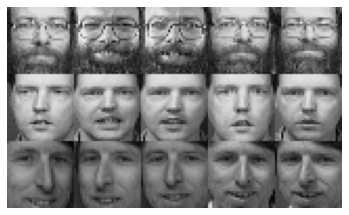

In [14]:
# Your code goes here
print("subjects 36 to 39 are the easist to be recognized: ")
show_faces(te_data[180:195, :], num_per_row=5)

 Pick some subjects that are considered the most difficult to recognise by your classifier, and print the misclassified test images from these subjects below.

subjects that are more difficult to be recognized are subjects:
{1, 3, 10, 13, 16, 22, 26}
misclassified images from them:


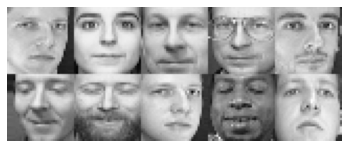

In [15]:
print("subjects that are more difficult to be recognized are subjects:")
misclassified_ind_copy = misclassified_ind
misclassified_subjects = set(misclassified_ind_copy//5+1)
print(misclassified_subjects)
# Show the face images that misclassified
print("misclassified images from them:")
show_faces(te_data[misclassified_ind, :], num_per_row=5)

#### Report

Explain the classification steps. How do you pick the most difficult and easiest subjects to classify,  analyse the results.

#### Experiment 3: Face Completion (4 Marks, Normal)

The task is to predic the 512 pixels of the right face from the 512 pixels of the left face by formulating a regression task.

The following command can be used to extract the left and right faces from the input data.

In [16]:
left, right = split_left_right(data)

And you can visualise them with the function `show_split_faces()`:

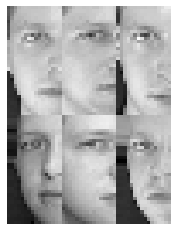

In [17]:
show_split_faces(left[:6, :], num_per_row=3)

Build a face completion model using your functions implemented earlier. Design an experiment to assess your model, which should include appropriate training and testing. Use mean absolute percentage error to evaluate the regression performance. You do not need to bother with hyper-parameter selection, but simply set $\lambda$=0.

Write your code below and make sure it compiles.

In [18]:
tr_ind, te_ind = partition_data(labels, num_per_class=5)
tr_data = left[tr_ind, :]
tr_label = right[tr_ind]
te_data = left[te_ind, :]
te_label = right[te_ind]

predict = recognize(tr_ind, tr_data, te_ind, te_data, right, 0)

MAPE = np.sum(np.absolute(te_label - predict)/np.absolute(te_label))/(512*200)
print("mean absolute percentage error: %f" % (MAPE))

mean absolute percentage error: 0.223282


Visualise and compare the ground truth face (include both the left and right parts) and the completed face (include both the true left and predicted right parts) for 3 randomly chosen testing samples below. You can use `join_left_right(left, right)` to concatenate the left and right halves of a set of faces.

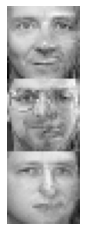

In [19]:
te_data = left[te_ind, :]
faces_ind = np.random.choice(200, 3, replace=False)
faces = join_left_right(te_data[faces_ind,:]*255, predict[faces_ind]*255)
show_faces(faces[:3, :], num_per_row=1)


#### Report

Analyse results of face completion model, how well your model performed, how it can be improved? 


## 4. Gradient descent for training linear least squares model (5 Marks in Total, Normal)

Now, implement the function `lls_gd_train` below. 

`lls_gd_train` trains a single-output linear model by minimising the sum of squares loss using the gradient descent approach. It should take the iteration number $N$ and the learning rate $\eta$ as the input. To keep things simple, you can fix the initial guess of the model weights $\mathbf{w}$ as zeros. It should record and return the weights and costs of linear least squares model calculated in all the iterations.

In [20]:
def lls_gd_train(data, labels, learning_rate, N # Add any other arguments here if needed
          ):
    """
    A summary of your function goes here.

    data: type and description of "data"
    labels: type and description of "labels"

    Returns: type and description of the returned variable(s).
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    Xtilde = np.c_[ np.ones(data.shape[0]), X  ]
    
    # Weight initialization
    try:
        w = np.zeros([Xtilde.shape[1],labels.shape[1]])
    except:
        w = np.zeros_like(Xtilde[0])
    cost = (1/2)*np.sum(np.square(Xtilde @ w - y))

    # GD update of weights
    cost_all = []
    w_all = []
    for i in range(N):
        
        # cost and gradient descent of the linear least squares model
        # This is the formula I derivived by myself, which is the gradient that has the smallest l2 norm
        # gradient = (w - Xtilde.T @ np.linalg.inv(Xtilde@Xtilde.T) @ y)
        gradient = Xtilde.T@Xtilde@w - Xtilde.T@y # for case N>d
        # Weight update
        w = w - (learning_rate * gradient)
        cost = (1/2)*np.sum(np.square(Xtilde @ w - y))

        # save w and cost of each iteration in w_all and cost_all 
        w_all.append(w)
        cost_all.append(cost)
    # Return model parameters.
    return (cost_all, w_all)

Apply this function to classify images from subject 1 and subject 30. You only need to conduct the experiment for one training-test trial, where 3 images from each subject are used for training and the remaining 7 images for testing.

Set your learning rate small, e.g., $\eta=10^{-3}$, and use a reasonable iteration number, e.g., $N=200$, to train your model. Plot in three figures (1) the change of your sum-of-squares error loss that you minimise, (2) the change of the classification accuracy for training samples, and (3) the change of the classification accuracy for test samples over iterations. Write your code below and make sure it compiles. 

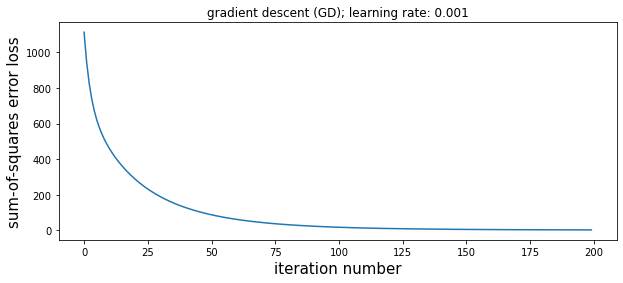

GD Iteration times to reduce error loss to 10:
121


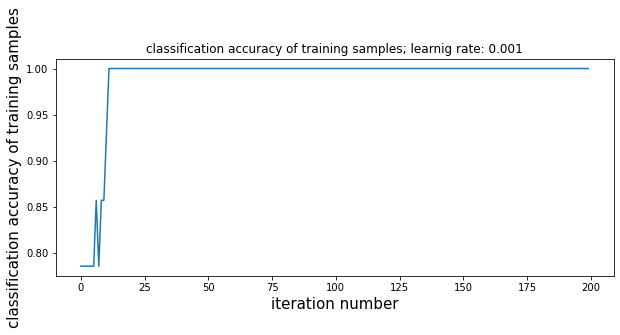

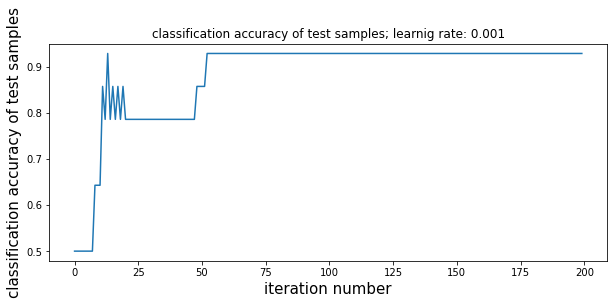

In [21]:
import matplotlib.pyplot as plt

def gradient_descent_ex_4(iteration_num,learning_rate):
    class_1_30_data, class_1_30_labels, tr_1_30_ind, te_1_30_ind = choose_data()
    tr_data = class_1_30_data[tr_1_30_ind, :]
    tr_label = class_1_30_labels[tr_1_30_ind]
    te_data = class_1_30_data[te_1_30_ind, :]
    te_label = class_1_30_labels[te_1_30_ind]

    result = lls_gd_train(tr_data, tr_label, learning_rate, iteration_num)
    error_loss = result[0]
    weight = result[1] # contrains all the updated models

    plt.figure(figsize=(10, 4))
    plt.xlabel("iteration number", size = 15)
    plt.ylabel("sum-of-squares error loss", size = 15)
    plt.title("gradient descent (GD); learning rate: "+str(learning_rate))
    plt.plot(error_loss)
    plt.show()

    # print(len(error_loss)-1)
    for i in range(len(error_loss)-1):
        if(error_loss[i]<10):
            print("GD Iteration times to reduce error loss to 10:")
            print(error_loss.index(error_loss[i]))
            break

    training_accuracy = []
    # Use every model in vector weight to predict
    for i in range(iteration_num):
        pre = l2_rls_predict(weight[i], tr_data)
        pre[pre<=15] = 1
        pre[pre>15] = 30
        dif =  pre - tr_label
        dif[dif!=0]=1
        error_rate = np.sum(dif)/14
        training_accuracy.append(1-error_rate)

    plt.figure(figsize=(10, 4))
    plt.xlabel("iteration number", size = 15)
    plt.ylabel("classification accuracy of training samples", size = 15)
    plt.title("classification accuracy of training samples; learnig rate: "+str(learning_rate))
    plt.plot(training_accuracy)
    plt.show()


    test_accuracy = []
    for i in range(iteration_num):
        pre = l2_rls_predict(weight[i], te_data)
        pre[pre<=15] = 1
        pre[pre>15] = 30
        dif =  pre - te_label
        dif[dif!=0]=1
        error_rate = np.sum(dif)/14
        test_accuracy.append(1-error_rate)

    plt.figure(figsize=(10, 4))
    plt.xlabel("iteration number", size = 15)
    plt.ylabel("classification accuracy of test samples", size = 15)
    plt.title("classification accuracy of test samples; learnig rate: "+str(learning_rate))
    plt.plot(test_accuracy)
    plt.show()

gradient_descent_ex_4(200,0.001)

Try a larger learning rate, e.g., $\eta=10^{-2}$, and produce the same three plots by training the model for $N=200$ iterations. Write your code below and make sure it compiles. 

/var/folders/fd/vhfk2_hs0257g84m9sjyc63w0000gn/T/ipykernel_52415/2796705.py:36: RuntimeWarning: overflow encountered in square
  cost = (1/2)*np.sum(np.square(Xtilde @ w - y))


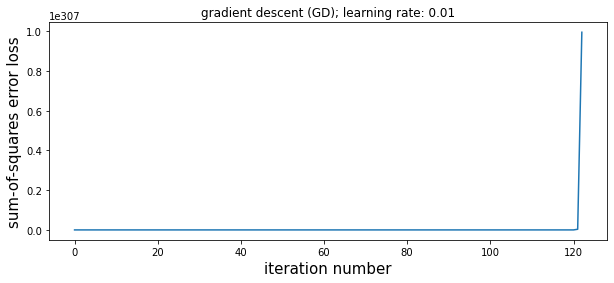

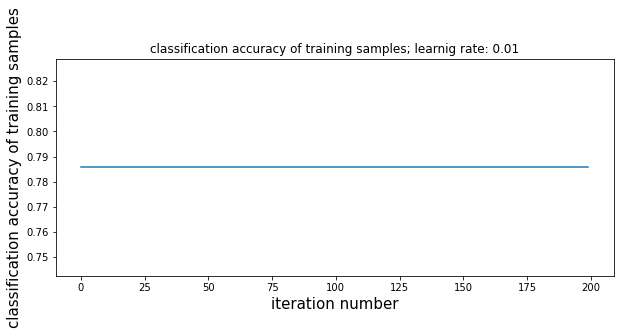

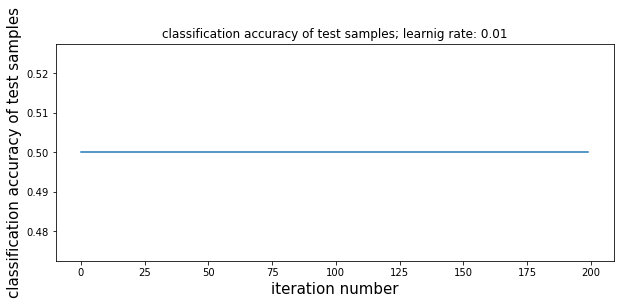

In [22]:
gradient_descent_ex_4(200,0.01)

#### Report

How  did you choose the learning rate and iteration number, explain your results. Explain the difference between two models : binary classification and mutli-class classification or binary classification and regression (whichever experiment you chose to implement).

## 5. Compare with stochastic gradient descent training (7 Marks In Total)
### 5.1 SGD Implementation (2 Marks, Normal)
Replace the gradient descent approach that you did in 4 with a stochastic gradient descent approach. Your new implementation can be named as `lls_sgd_train`. You can adopt the similar implementation template as used in your `lls_gd_train` function.

In [23]:
import random
def lls_sgd_train(data, labels, learning_rate, N # Add any other arguments here if needed
          ):
    """
    A summary of your function goes here.

    data: type and description of "data"
    labels: type and description of "labels"

    Returns: type and description of the returned variable(s).
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    # Expand X with a column of ones.
    Xtilde = np.c_[ np.ones(data.shape[0]), X  ]
    
    # Weight initialization
    try:
        w = np.zeros([Xtilde.shape[1],labels.shape[1]])
    except:
        w = np.zeros_like(Xtilde[0])
    # GD update of weights
    cost_all = []
    w_all = []

    for i in range(N):
        #select a random sample every time
        point = random.randint(0, Xtilde.shape[0]-1)
        # cost and gradient descent of the linear least squares model
        gradient = np.array([Xtilde[point]]).T @ np.array([Xtilde[point]]) @ w - np.array([Xtilde[point]]).T @ np.array([y[point]])
        # gradient = Xtilde.T@Xtilde@w - Xtilde.T@y
        # Weight update
        w = w.astype(float) - np.multiply(gradient,learning_rate).astype(float)
        cost = (1/2)*np.sum(np.square(Xtilde @ w - y))
        # save w and cost of each iteration in w_all and cost_all 
        w_all.append(w)
        cost_all.append(cost)
    # Return model parameters.
    return (cost_all, w_all)

### 5.2 Experiment Design (5 Marks, Hard)
Design and implement an appropriate experiment to demonstrate the perforamnce and behaviour difference between gradient descent and stochastic gradient descent. 


Stochastic gradient descent: 
Iteration number:1000, Learning rate: 0.001


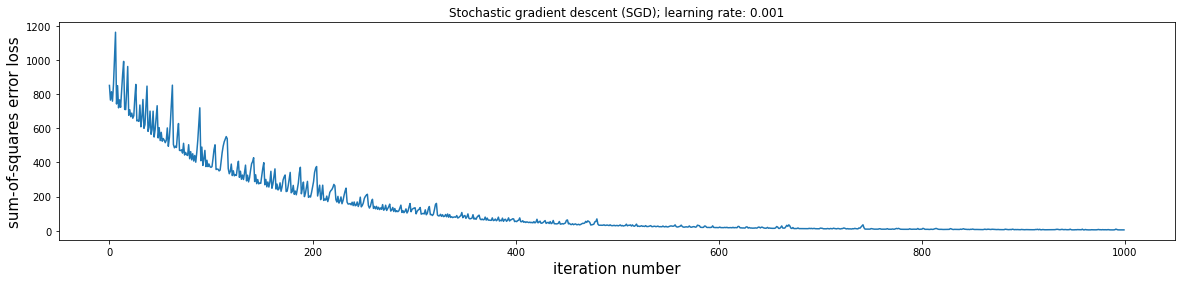

SGD Iteration times to reduce error loss to 10:
744


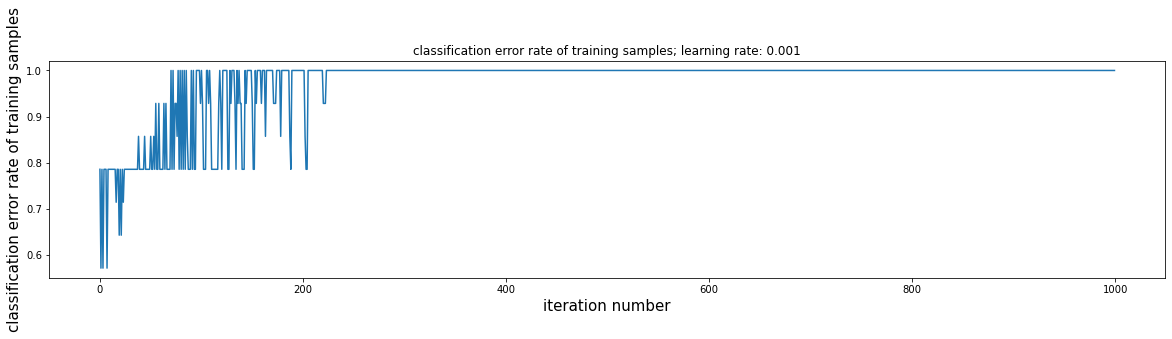

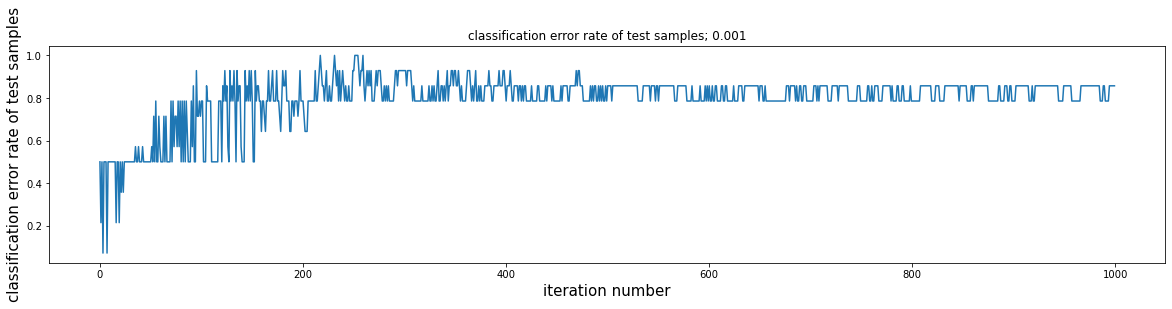

SGD running time: --- 2.3545360565185547 seconds ---

Iteration number:1000, Learning rate: 0.004


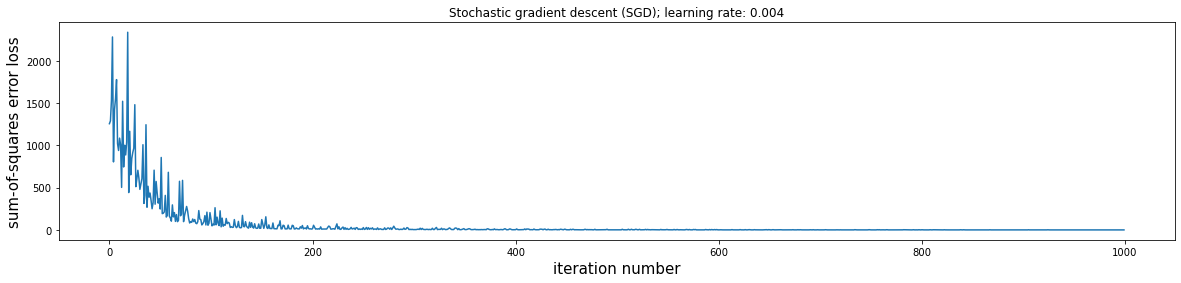

SGD Iteration times to reduce error loss to 10:
205


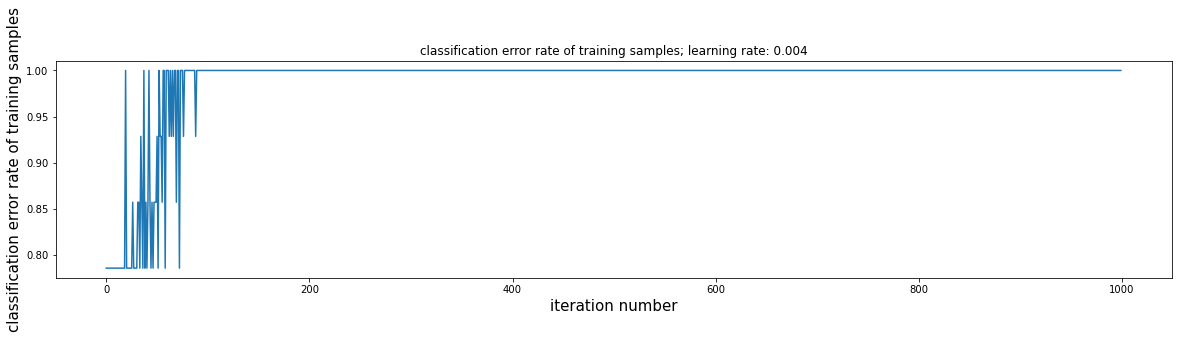

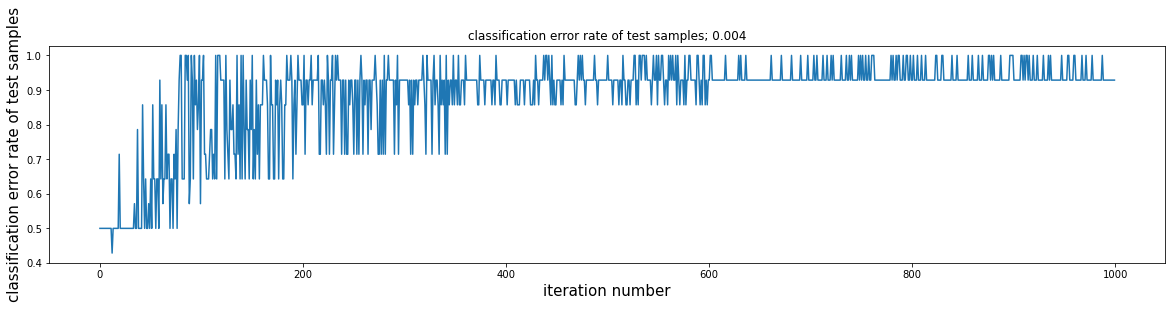

Gradient Descent: 
Iteration number:1000, Learning rate: 0.001


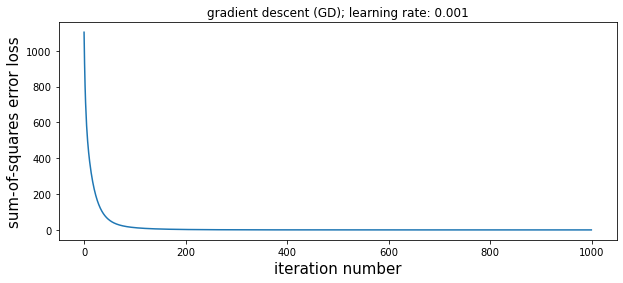

GD Iteration times to reduce error loss to 10:
112


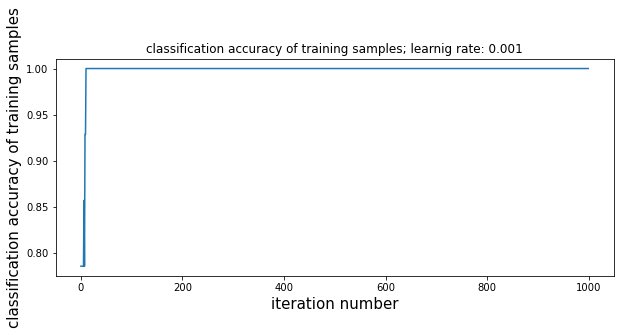

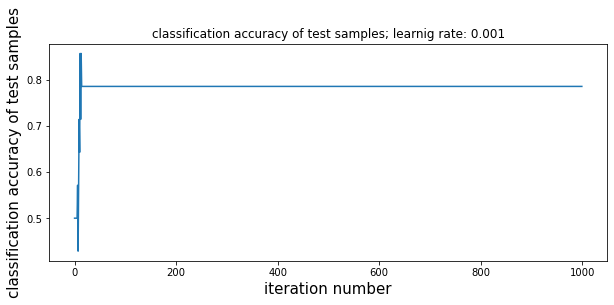

GD running time: --- 1.9611141681671143 seconds ---

Iteration number:1000, Learning rate: 0.002


/Users/mr.zheng/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/var/folders/fd/vhfk2_hs0257g84m9sjyc63w0000gn/T/ipykernel_52415/2796705.py:36: RuntimeWarning: overflow encountered in square
  cost = (1/2)*np.sum(np.square(Xtilde @ w - y))
/var/folders/fd/vhfk2_hs0257g84m9sjyc63w0000gn/T/ipykernel_52415/2796705.py:33: RuntimeWarning: overflow encountered in matmul
  gradient = Xtilde.T@Xtilde@w - Xtilde.T@y # for case N>d
/var/folders/fd/vhfk2_hs0257g84m9sjyc63w0000gn/T/ipykernel_52415/2796705.py:35: RuntimeWarning: invalid value encountered in subtract
  w = w - (learning_rate * gradient)


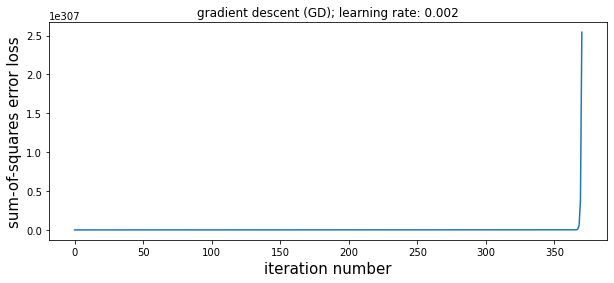

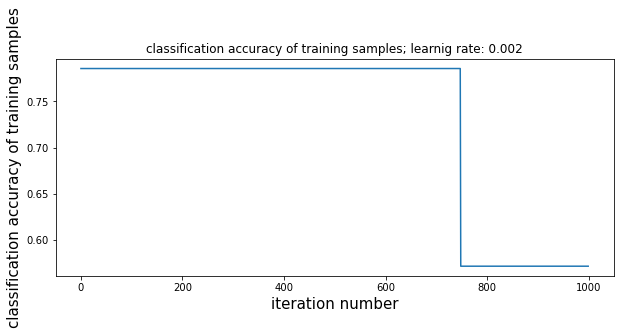

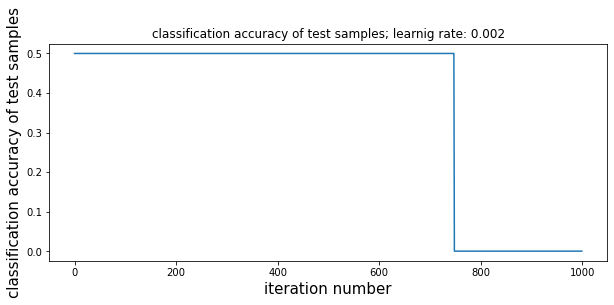

In [24]:
import time
import matplotlib.pyplot as plt
def sgd_bi_classification(iteration_num, learning_rate):
    class_1_30_data, class_1_30_labels, tr_1_30_ind, te_1_30_ind = choose_data()
    tr_data = class_1_30_data[tr_1_30_ind, :]
    tr_label = class_1_30_labels[tr_1_30_ind]
    te_data = class_1_30_data[te_1_30_ind, :]
    te_label = class_1_30_labels[te_1_30_ind]
    result = lls_sgd_train(tr_data, tr_label, learning_rate, iteration_num)
    error_loss = result[0]
    weight = result[1]

    plt.figure(figsize=(20, 4))
    plt.xlabel("iteration number", size = 15)
    plt.ylabel("sum-of-squares error loss", size = 15)
    plt.title("Stochastic gradient descent (SGD); learning rate: "+str(learning_rate))
    plt.plot(error_loss)
    plt.show()

    for i in range(len(error_loss)-1):
        if(error_loss[i]<10):
            print("SGD Iteration times to reduce error loss to 10:")
            print(error_loss.index(error_loss[i]))
            break


    training_accuracy =[]
    for i in range(iteration_num):
        pre = l2_rls_predict(weight[i], tr_data)
        pre[pre<=15.5] = 1
        pre[pre>15.5] = 30
        dif =  pre - tr_label
        dif[dif!=0]=1
        error_rate = np.sum(dif)/14
        training_accuracy.append(1-error_rate)

    plt.figure(figsize=(20, 4))
    plt.xlabel("iteration number", size = 15)
    plt.ylabel("classification error rate of training samples", size = 15)
    plt.title("classification error rate of training samples; learning rate: "+str(learning_rate))
    plt.plot(training_accuracy )
    plt.show()

    test_accuracy = []
    for i in range(iteration_num):
        pre = l2_rls_predict(weight[i], te_data)
        pre[pre<=15.5] = 1
        pre[pre>15.5] = 30
        dif =  pre - te_label
        dif[dif!=0]=1
        error_rate = np.sum(dif)/14
        test_accuracy .append(1-error_rate)

    plt.figure(figsize=(20, 4))
    plt.xlabel("iteration number", size = 15)
    plt.ylabel("classification error rate of test samples", size = 15)
    plt.title("classification error rate of test samples; "+str(learning_rate))
    plt.plot(test_accuracy )
    plt.show()

# SGD experiment
print("Stochastic gradient descent: ")
print("Iteration number:1000, Learning rate: 0.001")
#Record running time
start_time = time.time()
sgd_bi_classification(1000,0.001)
print("SGD running time: --- %s seconds ---" % (time.time() - start_time))

print("")
print("Iteration number:1000, Learning rate: 0.004")
sgd_bi_classification(1000,0.004)

#GD experiment
print("Gradient Descent: ")
print("Iteration number:1000, Learning rate: 0.001")
#Record running time
start_time = time.time()
gradient_descent_ex_4(1000,0.001)
print("GD running time: --- %s seconds ---" % (time.time() - start_time))

print("")
print("Iteration number:1000, Learning rate: 0.002")
gradient_descent_ex_4(1000,0.002)

#### Report  

Explain in the report your experiment design, comparative result analysis and interpretation of obtained results. Try to be thorough in your analysis.

#### Remember that all graphs should have axis labels and a title.